In [1]:
import numpy as np
from random import shuffle
from scipy.stats import entropy
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import nashpy as nash
import random
import time
import open_spiel
import pyspiel
from open_spiel.python.algorithms import lp_solver

In [2]:
"""
Row player max, col player min
"""

'\nRow player max, col player min\n'

In [3]:
def get_br_to_strat(strat, payoffs, strat_is_row=True, verbose=False, random=False):
    if strat_is_row:
        weighted_payouts = strat@payoffs
        if random:
            weighted_payouts += np.random.rand(weighted_payouts.shape[0])/200
        if verbose:
            print("strat ", strat)
            print("weighted payouts ", weighted_payouts)
        
        br = np.zeros_like(weighted_payouts)
        br[np.argmin(weighted_payouts)] = 1
        idx = np.argmin(weighted_payouts)
    else:
        weighted_payouts = payoffs@strat.T
        if random:
            weighted_payouts += np.random.rand(weighted_payouts.shape[0])/200
        if verbose:
            print("strat ", strat)
            print("weighted payouts ", weighted_payouts)
            
        br = np.zeros_like(weighted_payouts)
        br[np.argmax(weighted_payouts)] = 1
        idx = np.argmax(weighted_payouts)
    return br, idx

In [4]:
def fictitious_play(payoffs, iters=2000, verbose=False):
    row_dim = payoffs.shape[0]
    col_dim = payoffs.shape[1]
    row_pop = np.random.uniform(0,1,(1, row_dim))
    row_pop = row_pop/row_pop.sum(axis=1)[:,None]
    row_averages = row_pop
    col_pop = np.random.uniform(0,1,(1, col_dim))
    col_pop = col_pop/col_pop.sum(axis=1)[:,None]
    col_averages = col_pop
    start_time = time.time()
    times = []
    exps = []
    for i in range(iters):
        row_average = np.average(row_pop, axis=0)
        col_average = np.average(col_pop, axis=0)
   
        row_br, idx = get_br_to_strat(col_average, payoffs, strat_is_row=False, verbose=False) 
        col_br, idx = get_br_to_strat(row_average, payoffs, strat_is_row=True, verbose=False)
        
        exp1 = row_average@payoffs@col_br.T
        exp2 = row_br@payoffs@col_average.T
        exps.append(exp2-exp1)
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)        
        if verbose:
            print(exps[-1], "exploitability")
        
        row_averages = np.vstack((row_averages, row_average))
        col_averages = np.vstack((col_averages, col_average))
        
        row_pop = np.vstack((row_pop, row_br))
        col_pop = np.vstack((col_pop, col_br))
    return row_averages, col_averages, exps, times 

In [5]:
def get_exploitability(row_pop, col_pop, payoffs, iters=1000):
    emp_game_matrix = row_pop@payoffs@col_pop.T
    row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=iters)
    row_strat = row_averages[-1]@row_pop
    col_br, idx = get_br_to_strat(row_strat, payoffs=payoffs, strat_is_row=True)
    col_strat = col_averages[-1]@col_pop
    row_br, idx = get_br_to_strat(col_strat, payoffs=payoffs, strat_is_row=False)
    exp1 = row_strat@payoffs@col_br.T
    exp2 = row_br@payoffs@col_strat
    return exp2 - exp1

In [17]:
def double_oracle(payoffs, iters=2000, custom_row_strat=np.array([0]), custom_col_strat=np.array([0]), random=False):
    row_dim = payoffs.shape[0]
    col_dim = payoffs.shape[1]
    row_pop = np.random.uniform(0,1,(1, row_dim))
    row_pop = row_pop/row_pop.sum(axis=1)[:,None]
    if custom_row_strat.any():
        row_pop = custom_row_strat
#     print(row_pop, "row pop")
    row_averages = row_pop
    col_pop = np.random.uniform(0,1,(1, col_dim))
    col_pop = col_pop/col_pop.sum(axis=1)[:,None]
    if custom_col_strat.any():
        col_pop = custom_col_strat
#     print(col_pop, "col pop")
    col_averages = col_pop
    row_indices = []
    col_indices = []
    start_time = time.time()
    times = []
    exps = []
    for i in range(iters):
#         print("Iteration: ", i+1)
        emp_game_matrix = row_pop@payoffs@col_pop.T
        row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=3000)
        nash_prob_1, nash_prob_2, _, _ = lp_solver.solve_zero_sum_matrix_game(
            pyspiel.create_matrix_game(emp_game_matrix, -emp_game_matrix))
        norm_pos1 = abs(nash_prob_1) / sum(abs(nash_prob_1))
        norm_pos2 = abs(nash_prob_2) / sum(abs(nash_prob_2))
        row_nash = np.reshape(np.array(norm_pos1), (np.array(norm_pos1).shape[0],)) 
        col_nash = np.reshape(np.array(norm_pos2), (np.array(norm_pos2).shape[0],))
               
#         row_strat = row_averages[-1]@row_pop
#         col_strat = col_averages[-1]@col_pop       
        row_strat = row_nash@row_pop
        col_strat = col_nash@col_pop
    
        row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False, random=random) 
        col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False, random=random)
        
#         print("Row Index: ", row_idx+1)
#         print("Column Index: ", col_idx+1)        

        if row_idx in row_indices and col_idx in col_indices:
#             print(row_indices, col_indices)
#             print('num iters do: ', i)
            return row_pop, col_pop, row_strat, col_strat, exps, times, row_indices, col_indices
        row_indices.append(row_idx)
        col_indices.append(col_idx)
        
        row_pop = np.vstack((row_pop, row_br))
        col_pop = np.vstack((col_pop, col_br))
        
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)

        exp = get_exploitability(row_pop, col_pop, payoffs)
        exps.append(exp)

    return row_pop, col_pop, row_strat, col_strat, exps, times, row_indices, col_indices      


In [7]:
def combine_two_payoffs(payoff1, payoff2):
    rows = payoff1.shape[0]
    cols = payoff1.shape[1]
    new_payoffs = np.zeros((rows**2, cols*2))
    for row1 in range(rows):
        for row2 in range(rows):
            for col in range(cols):
                new_payoffs[rows*row1 + row2, col] = payoff1[row1, col]
            for col in range(cols):
                new_payoffs[rows*row1 + row2, cols + col] = payoff2[row2, col]
    return new_payoffs

In [8]:
def phantom(payoff1, payoff2):
    rows = payoff1.shape[0]
    cols = payoff1.shape[1]
    new_payoffs = np.zeros((rows**2, cols**2))
    for row1 in range(rows):
        for row2 in range(rows):
            for col1 in range(cols):
                for col2 in range(cols):
                    new_payoffs[rows*row1 + row2, cols*col1 + col2] = payoff1[row1, col1] + payoff2[row2, col2]
    return new_payoffs

In [27]:
num_exps = 2000
dim = 3
max_iters = 0
RPS = np.array([[0,-1,1],[1,0,-1],[-1,1,0]])
payoff1 = np.random.rand(dim, dim)
payoff2 = np.random.rand(dim, dim)
payoffs = combine_two_payoffs(payoff1, payoff2)
# payoffs = phantom(payoff1, payoff2)
payoffs = combine_two_payoffs(RPS, RPS)
payoffs = combine_two_payoffs(payoffs, payoffs)
print(payoffs)
# payoffs = np.array([[1,-1,0,-1,1],[1,-1,1,0,-1],[1,-1,-1,1,0],[-1,1,0,-1,1],[-1,1,1,0,-1],[-1,1,-1,1,0]])
# payoffs = combine_two_payoffs(payoffs, payoffs)
max_iters = 0
# row_pop = np.array([[0.05231937, 0.14150243, 0.10368032, 0.06769667, 0.16936753, 0.21600081, 
#                      0.02191275, 0.19459428, 0.03292585]])
# col_pop = np.array([[0.26429856, 0.31157599, 0.00243366, 0.20676244, 0.06402573, 0.15090363]])
num_row_strats_list = []
num_col_strats_list = []
for i in range(num_exps):
    _, _, _, _, _, _, row_indices, col_indices = double_oracle(payoffs, 
#                                                                custom_row_strat=row_pop,
#                                                                custom_col_strat=col_pop,
                                                               random=False) 
    num_row_strats = len(list(set(row_indices)))
    num_col_strats = len(list(set(col_indices)))
    num_row_strats_list.append(num_row_strats)
    num_col_strats_list.append(num_col_strats)
    print('iter: ', i)
    print(num_row_strats, 'row')
    print(num_col_strats, 'col')
#     print(row_indices, 'row indices')
#     print(col_indices, 'col indices')
#     print("iter: ", i, "num row strats: ", num_row_strats)
#     if num_row_strats > max_iters:
#         max_iters = num_row_strats
#         print('New max iters: ', max_iters)

[[ 0. -1.  1.  0. -1.  1.  0. -1.  1.  0. -1.  1.]
 [ 0. -1.  1.  0. -1.  1.  0. -1.  1.  1.  0. -1.]
 [ 0. -1.  1.  0. -1.  1.  0. -1.  1. -1.  1.  0.]
 [ 0. -1.  1.  0. -1.  1.  1.  0. -1.  0. -1.  1.]
 [ 0. -1.  1.  0. -1.  1.  1.  0. -1.  1.  0. -1.]
 [ 0. -1.  1.  0. -1.  1.  1.  0. -1. -1.  1.  0.]
 [ 0. -1.  1.  0. -1.  1. -1.  1.  0.  0. -1.  1.]
 [ 0. -1.  1.  0. -1.  1. -1.  1.  0.  1.  0. -1.]
 [ 0. -1.  1.  0. -1.  1. -1.  1.  0. -1.  1.  0.]
 [ 0. -1.  1.  1.  0. -1.  0. -1.  1.  0. -1.  1.]
 [ 0. -1.  1.  1.  0. -1.  0. -1.  1.  1.  0. -1.]
 [ 0. -1.  1.  1.  0. -1.  0. -1.  1. -1.  1.  0.]
 [ 0. -1.  1.  1.  0. -1.  1.  0. -1.  0. -1.  1.]
 [ 0. -1.  1.  1.  0. -1.  1.  0. -1.  1.  0. -1.]
 [ 0. -1.  1.  1.  0. -1.  1.  0. -1. -1.  1.  0.]
 [ 0. -1.  1.  1.  0. -1. -1.  1.  0.  0. -1.  1.]
 [ 0. -1.  1.  1.  0. -1. -1.  1.  0.  1.  0. -1.]
 [ 0. -1.  1.  1.  0. -1. -1.  1.  0. -1.  1.  0.]
 [ 0. -1.  1. -1.  1.  0.  0. -1.  1.  0. -1.  1.]
 [ 0. -1.  1. -1.  1.  0.  0. -

iter:  167
18 row
12 col
iter:  168
24 row
12 col
iter:  169
23 row
12 col
iter:  170
20 row
12 col
iter:  171
16 row
12 col
iter:  172
25 row
12 col
iter:  173
22 row
12 col
iter:  174
22 row
12 col
iter:  175
22 row
12 col
iter:  176
31 row
12 col
iter:  177
19 row
12 col
iter:  178
27 row
12 col
iter:  179
28 row
12 col
iter:  180
20 row
12 col
iter:  181
32 row
12 col
iter:  182
24 row
12 col
iter:  183
30 row
12 col
iter:  184
28 row
12 col
iter:  185
23 row
12 col
iter:  186
26 row
12 col
iter:  187
22 row
12 col
iter:  188
18 row
12 col
iter:  189
26 row
12 col
iter:  190
17 row
12 col
iter:  191
29 row
12 col
iter:  192
24 row
12 col
iter:  193
29 row
12 col
iter:  194
18 row
12 col
iter:  195
22 row
12 col
iter:  196
25 row
12 col
iter:  197
21 row
12 col
iter:  198
30 row
12 col
iter:  199
22 row
12 col
iter:  200
16 row
12 col
iter:  201
25 row
12 col
iter:  202
21 row
12 col
iter:  203
19 row
12 col
iter:  204
25 row
12 col
iter:  205
26 row
12 col
iter:  206
25 row
12 col


iter:  495
17 row
12 col
iter:  496
23 row
12 col
iter:  497
16 row
12 col
iter:  498
29 row
12 col
iter:  499
18 row
12 col
iter:  500
31 row
12 col
iter:  501
20 row
12 col
iter:  502
26 row
12 col
iter:  503
17 row
12 col
iter:  504
25 row
12 col
iter:  505
26 row
12 col
iter:  506
20 row
12 col
iter:  507
22 row
12 col
iter:  508
18 row
12 col
iter:  509
24 row
12 col
iter:  510
22 row
12 col
iter:  511
17 row
12 col
iter:  512
19 row
12 col
iter:  513
34 row
12 col
iter:  514
25 row
12 col
iter:  515
24 row
12 col
iter:  516
22 row
12 col
iter:  517
23 row
12 col
iter:  518
31 row
12 col
iter:  519
18 row
12 col
iter:  520
20 row
12 col
iter:  521
26 row
12 col
iter:  522
22 row
12 col
iter:  523
27 row
12 col
iter:  524
30 row
12 col
iter:  525
24 row
12 col
iter:  526
22 row
12 col
iter:  527
22 row
12 col
iter:  528
19 row
12 col
iter:  529
24 row
12 col
iter:  530
18 row
12 col
iter:  531
16 row
12 col
iter:  532
22 row
12 col
iter:  533
20 row
12 col
iter:  534
24 row
12 col


iter:  823
29 row
12 col
iter:  824
24 row
12 col
iter:  825
18 row
12 col
iter:  826
33 row
12 col
iter:  827
27 row
12 col
iter:  828
26 row
12 col
iter:  829
30 row
12 col
iter:  830
14 row
12 col
iter:  831
26 row
12 col
iter:  832
20 row
12 col
iter:  833
31 row
12 col
iter:  834
23 row
12 col
iter:  835
21 row
12 col
iter:  836
24 row
12 col
iter:  837
15 row
12 col
iter:  838
22 row
12 col
iter:  839
24 row
12 col
iter:  840
22 row
12 col
iter:  841
18 row
12 col
iter:  842
34 row
12 col
iter:  843
26 row
12 col
iter:  844
19 row
12 col
iter:  845
19 row
12 col
iter:  846
21 row
12 col
iter:  847
25 row
12 col
iter:  848
22 row
12 col
iter:  849
26 row
12 col
iter:  850
20 row
12 col
iter:  851
20 row
12 col
iter:  852
26 row
12 col
iter:  853
20 row
12 col
iter:  854
19 row
12 col
iter:  855
21 row
12 col
iter:  856
18 row
12 col
iter:  857
28 row
12 col
iter:  858
23 row
12 col
iter:  859
18 row
12 col
iter:  860
21 row
12 col
iter:  861
21 row
12 col
iter:  862
22 row
12 col


iter:  1145
20 row
12 col
iter:  1146
30 row
12 col
iter:  1147
21 row
12 col
iter:  1148
23 row
12 col
iter:  1149
17 row
12 col
iter:  1150
22 row
12 col
iter:  1151
26 row
12 col
iter:  1152
19 row
12 col
iter:  1153
25 row
12 col
iter:  1154
22 row
12 col
iter:  1155
19 row
12 col
iter:  1156
25 row
12 col
iter:  1157
19 row
12 col
iter:  1158
20 row
12 col
iter:  1159
27 row
12 col
iter:  1160
19 row
12 col
iter:  1161
27 row
12 col
iter:  1162
19 row
12 col
iter:  1163
26 row
12 col
iter:  1164
18 row
12 col
iter:  1165
22 row
12 col
iter:  1166
19 row
12 col
iter:  1167
24 row
12 col
iter:  1168
22 row
12 col
iter:  1169
19 row
12 col
iter:  1170
26 row
12 col
iter:  1171
20 row
12 col
iter:  1172
19 row
12 col
iter:  1173
18 row
12 col
iter:  1174
22 row
12 col
iter:  1175
18 row
12 col
iter:  1176
21 row
12 col
iter:  1177
18 row
12 col
iter:  1178
19 row
12 col
iter:  1179
19 row
12 col
iter:  1180
21 row
12 col
iter:  1181
20 row
12 col
iter:  1182
21 row
12 col
iter:  1183


iter:  1461
26 row
12 col
iter:  1462
17 row
12 col
iter:  1463
20 row
12 col
iter:  1464
18 row
12 col
iter:  1465
26 row
12 col
iter:  1466
24 row
12 col
iter:  1467
23 row
12 col
iter:  1468
17 row
12 col
iter:  1469
27 row
12 col
iter:  1470
25 row
12 col
iter:  1471
22 row
12 col
iter:  1472
28 row
12 col
iter:  1473
20 row
12 col
iter:  1474
26 row
12 col
iter:  1475
21 row
12 col
iter:  1476
25 row
12 col
iter:  1477
34 row
12 col
iter:  1478
24 row
12 col
iter:  1479
25 row
12 col
iter:  1480
18 row
12 col
iter:  1481
26 row
12 col
iter:  1482
23 row
12 col
iter:  1483
28 row
12 col
iter:  1484
25 row
12 col
iter:  1485
21 row
12 col
iter:  1486
19 row
12 col
iter:  1487
23 row
12 col
iter:  1488
22 row
12 col
iter:  1489
19 row
12 col
iter:  1490
29 row
12 col
iter:  1491
22 row
12 col
iter:  1492
21 row
12 col
iter:  1493
21 row
12 col
iter:  1494
26 row
12 col
iter:  1495
20 row
12 col
iter:  1496
21 row
12 col
iter:  1497
20 row
12 col
iter:  1498
27 row
12 col
iter:  1499


iter:  1777
27 row
12 col
iter:  1778
28 row
12 col
iter:  1779
28 row
12 col
iter:  1780
17 row
12 col
iter:  1781
27 row
12 col
iter:  1782
26 row
12 col
iter:  1783
21 row
12 col
iter:  1784
19 row
12 col
iter:  1785
25 row
12 col
iter:  1786
20 row
12 col
iter:  1787
23 row
12 col
iter:  1788
23 row
12 col
iter:  1789
20 row
12 col
iter:  1790
24 row
12 col
iter:  1791
22 row
12 col
iter:  1792
17 row
12 col
iter:  1793
20 row
12 col
iter:  1794
27 row
12 col
iter:  1795
25 row
12 col
iter:  1796
27 row
12 col
iter:  1797
21 row
12 col
iter:  1798
26 row
12 col
iter:  1799
23 row
12 col
iter:  1800
18 row
12 col
iter:  1801
26 row
12 col
iter:  1802
24 row
12 col
iter:  1803
19 row
12 col
iter:  1804
26 row
12 col
iter:  1805
26 row
12 col
iter:  1806
23 row
12 col
iter:  1807
26 row
12 col
iter:  1808
19 row
12 col
iter:  1809
16 row
12 col
iter:  1810
18 row
12 col
iter:  1811
17 row
12 col
iter:  1812
23 row
12 col
iter:  1813
29 row
12 col
iter:  1814
27 row
12 col
iter:  1815


(array([  0.,   0.,   0.,   0.,   0.,   0.,   3.,  25., 122.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

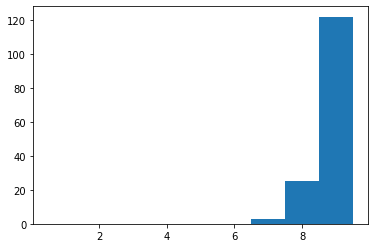

In [23]:
plt.hist(num_row_strats_list[:150], bins=[i for i in range(10)], align='right', )

(array([  0.,   0.,   0.,   0.,   0.,   0., 150.,   0.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

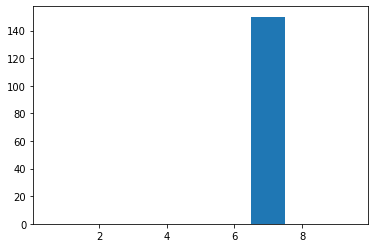

In [24]:
plt.hist(num_col_strats_list[:150], bins=[i for i in range(10)], align='right', )

In [ ]:
num_exps = 30
maxes = []
dim_list = [3, 5, 10, 15, 25]
for dim in dim_list:
    max_iters = 0
    for i in range(num_exps):
        payoff1 = np.random.rand(dim, dim)
        payoff2 = np.random.rand(dim, dim)
#         payoffs = combine_two_payoffs(payoff1, payoff2)
        payoffs = phantom(payoff1, payoff2)
        row_pop, col_pop, row_strat, col_strat, exps, times = double_oracle(payoffs)      
        if len(exps) > max_iters:
            max_iters = len(exps)
    print("dim: ", dim, "max: ", max_iters)
    maxes.append(max_iters)
plt.plot(dim_list, maxes)

In [ ]:
payoffs = np.array([[1,0,2,-1,-2,0],[2,1,0,0,-1,-2],[0,2,1,-2,0,-1],[-1,-2,0,1,0,2],
                    [0,-1,-2,2,1,0],[-2,0,-1,0,2,1]])
payoffs = np.array([[1,-1,0,-1,1],[1,-1,1,0,-1],[1,-1,-1,1,0],[-1,1,0,-1,1],[-1,1,1,0,-1],[-1,1,-1,1,0]])

row_dim = payoffs.shape[0]
row_pop = np.zeros((1, row_dim))
row_pop[0, 0] = 1
col_dim = payoffs.shape[1]
col_pop = np.zeros((1, col_dim))
col_pop[0, 0] = 1

print(payoffs)

emp_game_matrix = row_pop@payoffs@col_pop.T
row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=1000)
row_strat = row_averages[-1]@row_pop
col_strat = col_averages[-1]@col_pop

# print(row_strat, 'row strat')
# print(col_strat, 'col strat')
# print(payoffs@col_strat.T, 'weighted row payoffs')
# print(-row_strat@payoffs, 'weighted col payoffs')

row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False, random=True) 
col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False, random=True)
print(row_idx, 'row idx')
print(col_idx, 'col idx')

print("round 2-------------")
row_pop = np.vstack((row_pop, row_br))
col_pop = np.vstack((col_pop, col_br))
emp_game_matrix = row_pop@payoffs@col_pop.T
row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=1000)
row_strat = row_averages[-1]@row_pop
col_strat = col_averages[-1]@col_pop

# print(row_strat, 'row strat')
# print(col_strat, 'col strat')
# print(payoffs@col_strat.T, 'weighted payoffs')
# print(-row_strat@payoffs, 'weighted col payoffs')


row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False, random=True) 
col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False, random=True)
print(row_idx, 'row idx')
print(col_idx, 'col idx')

print("round 3-------------")
row_pop = np.vstack((row_pop, row_br))
col_pop = np.vstack((col_pop, col_br))
emp_game_matrix = row_pop@payoffs@col_pop.T
row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=1000)
row_strat = row_averages[-1]@row_pop
col_strat = col_averages[-1]@col_pop

# print(row_strat, 'row strat')
# print(col_strat, 'col strat')
# print(payoffs@col_strat.T, 'weighted payoffs')
# print(-row_strat@payoffs, 'weighted col payoffs')


row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False, random=True) 
col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False, random=True)
print(row_idx, 'row idx')
print(col_idx, 'col idx')

print("round 4-------------")
row_pop = np.vstack((row_pop, row_br))
col_pop = np.vstack((col_pop, col_br))
emp_game_matrix = row_pop@payoffs@col_pop.T
row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=1000)
row_strat = row_averages[-1]@row_pop
col_strat = col_averages[-1]@col_pop

# print(row_strat, 'row strat')
# print(col_strat, 'col strat')
# print(payoffs@col_strat.T, 'weighted payoffs')
# print(-row_strat@payoffs, 'weighted col payoffs')

row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False, random=True) 
col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False, random=True)
print(row_idx, 'row idx')
print(col_idx, 'col idx')

print("round 5-------------")
row_pop = np.vstack((row_pop, row_br))
col_pop = np.vstack((col_pop, col_br))
emp_game_matrix = row_pop@payoffs@col_pop.T
row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=1000)
row_strat = row_averages[-1]@row_pop
col_strat = col_averages[-1]@col_pop

# print(row_strat, 'row strat')
# print(col_strat, 'col strat')
# print(payoffs@col_strat.T, 'weighted payoffs')
# print(-row_strat@payoffs, 'weighted col payoffs')


row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False, random=True) 
col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False, random=True)
print(row_idx, 'row idx')
print(col_idx, 'col idx')

print("round 6-------------")
row_pop = np.vstack((row_pop, row_br))
col_pop = np.vstack((col_pop, col_br))
emp_game_matrix = row_pop@payoffs@col_pop.T
row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=1000)
row_strat = row_averages[-1]@row_pop
col_strat = col_averages[-1]@col_pop

# print(row_strat, 'row strat')
# print(col_strat, 'col strat')
# print(payoffs@col_strat.T, 'weighted payoffs')
# print(-row_strat@payoffs, 'weighted col payoffs')


row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False, random=True) 
col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False, random=True)
print(row_idx, 'row idx')
print(col_idx, 'col idx')

print("round 7-------------")
row_pop = np.vstack((row_pop, row_br))
col_pop = np.vstack((col_pop, col_br))
emp_game_matrix = row_pop@payoffs@col_pop.T
row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=1000)
row_strat = row_averages[-1]@row_pop
col_strat = col_averages[-1]@col_pop

# print(row_strat, 'row strat')
# print(col_strat, 'col strat')
# print(payoffs@col_strat.T, 'weighted payoffs')
# print(-row_strat@payoffs, 'weighted col payoffs')


row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False, random=True) 
col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False, random=True)
print(row_idx, 'row idx')
print(col_idx, 'col idx')

In [ ]:
plt.plot(dim_list, maxes)
plt.ylabel("max number of PSRO iters")
plt.xlabel("number of actions in both games")

In [ ]:
for i in range(row_pop.shape[0]):
    print(np.argmax(row_pop[i]), 'row')
    print(np.argmax(col_pop[i]), 'col')

In [ ]:
row_strat[-1]

In [ ]:
matrix = np.array([[1,1,1,0,0,0,0,0,0], 
                   [0,0,0,1,1,1,0,0,0],
                   [0,0,0,0,0,0,1,1,1],
                   [1,0,0,1,0,0,1,0,0],
                   [0,1,0,0,1,0,0,1,0],
                   [0,0,1,0,0,1,0,0,1]])
matrix

In [ ]:
np.linalg.matrix_rank(matrix)